# Load data

In [71]:
import torch
import torchvision
from torchvision import transforms

mnist = torchvision.datasets.MNIST(
    root='../../data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist,
    batch_size=128,
    shuffle=True
)

# Model training

In [75]:
from models import Generator
from models import Discriminator
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

if not os.path.isdir('./imgs'):
    os.mkdir('./imgs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 201
lr = 0.0002
latent_dim = 100
image_dim = 28 * 28
g_layers = [256, 512]
d_layers = [512, 256]

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=lr)
d_optimizer = optim.Adam(D.parameters(), lr=lr)

history = {
    'd_loss': [],
    'g_loss': [],
    'real_score': [],
    'fake_score': [],
    'fake_img': []
}

# start training
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(data_loader):
        # train Discriminator
        real_labels = torch.ones(len(real_imgs), 1).to(device)
        fake_labels = torch.zeros(len(real_imgs), 1).to(device)
        real_imgs = real_imgs.reshape(len(real_imgs), image_dim).to(device)
        z = torch.randn(len(real_imgs), latent_dim).to(device)
        fake_imgs = G(z).detach()
        
        d_out_real = D(real_imgs)
        d_out_fake = D(fake_imgs)
        
        d_loss = criterion(d_out_real, real_labels) + criterion(d_out_fake, fake_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # train Generator
        z = torch.randn(len(real_imgs), latent_dim).to(device)
        fake_imgs = G(z)
        
        g_loss = criterion(D(fake_imgs), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # log history
    history['d_loss'].append(d_loss.item())
    history['g_loss'].append(g_loss.item())
    history['real_score'].append(d_out_real.mean().item())
    history['fake_score'].append(d_out_fake.mean().item())
    
    # save fake images
    if epoch % 10 == 0:
        torchvision.utils.save_image(fake_imgs.reshape(len(fake_imgs), 1, 28, 28), f'./imgs/fake-{epoch}.png', normalize=True)

for key in history.keys():
    history[key] = np.array(history[key])

# Plot result

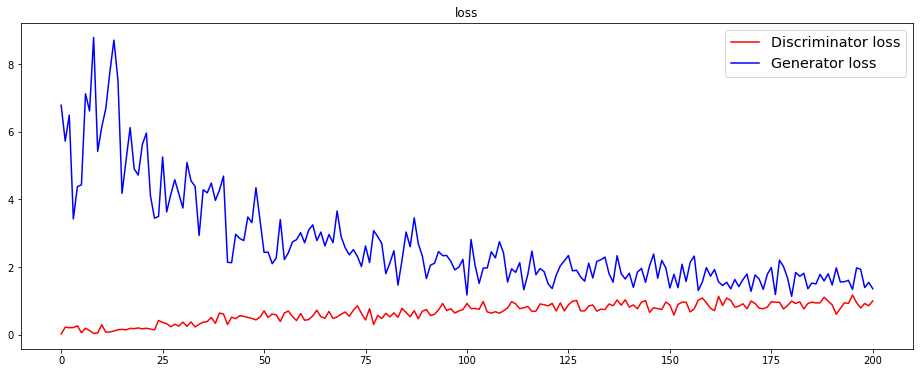

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.title('loss')
plt.plot(history['d_loss'], 'r-')
plt.plot(history['g_loss'], 'b-')
plt.legend(['Discriminator loss', 'Generator loss'], fontsize='x-large')
plt.show()

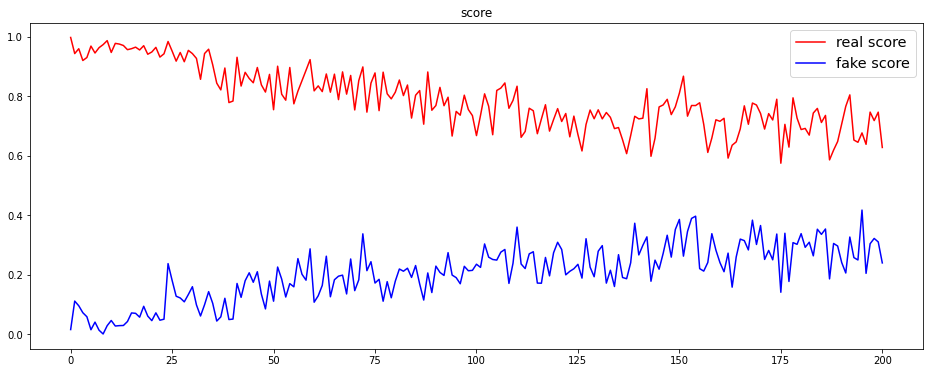

In [77]:
plt.figure(figsize=(16, 6))
plt.title('score')
plt.plot(history['real_score'], 'r-')
plt.plot(history['fake_score'], 'b-')
plt.legend(['real score', 'fake score'], fontsize='x-large')
plt.show()